# Summary of Findings for improving the CM Use Case

In [1]:
import numpy as np

from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo

# functions from CM_source code notebook
from mip_builder import (
    _create_mip_objective,
    _mip_const_buckets,
    _mip_const_power_balance,
    _mip_const_transformer,
    _mip_const_branch,
    _mip_const_producers_change,
    _mip_const_producers_time,
    _qubo_converter
)

# for graph structure
import networkx as nx
import matplotlib.pyplot as plt

# for graph structure + feasibility
from dwave.system import DWaveSampler, EmbeddingComposite
import dwave.inspector as dwinspector

# for feasibility benchmark
from neal import SimulatedAnnealingSampler

In [2]:
# helper function to create MIP

def create_mip_with_variable_scaling(power_scale=1, trafo_scale=1):
    """
    Scale factors change the corresponding physical quanties according to X/scale_factor.
    """
    
    # Define variables affected by power scale again within local scope
    V_P = [[0, 500, 1000, 1500, 2000], [0, 200, 400, 600, 800]]
    P_0_T = [700, 1600]
    P_0_P_T = [[500, 1000], [200, 600]]
    P_MIN = -1000
    P_MAX = 1000
    S_P_B = [[1, 2], [1, 1]]
    
    # Define variables affected by trafo scale again within local scope
    V_S = [[-10, -5, +5, +10]]
    S_MIN = -20
    S_MAX = +20
    S_0_TRAN_T = [[+10, +10]] 
    S_TRAN_B = [[1, 4], [2, 3]]
    
    if power_scale != 1:
        V_P = [[entry/power_scale for entry in row] for row in V_P]
        P_0_T = [entry/power_scale for entry in P_0_T]
        P_0_P_T =[[entry/power_scale for entry in row] for row in P_0_P_T]
        P_MIN = P_MIN/power_scale
        P_MAX = P_MAX/power_scale

        # physicality: plant sensitivity values have to be scaled up
        S_P_B = [[entry*power_scale for entry in row] for row in S_P_B]
        
    if trafo_scale != 1:
        V_S = [[entry/trafo_scale for entry in row] for row in V_S]
        S_MIN = S_MIN/trafo_scale
        S_MAX = S_MAX/trafo_scale
        S_0_TRAN_T = [[entry/trafo_scale for entry in row] for row in S_0_TRAN_T]

        # physicality: transformator sensitivity values have to be scaled up
        S_TRAN_B = [[trafo_scale*entry for entry in row] for row in S_TRAN_B]
        

    mip, lst_vars = _create_mip_objective(P, T, TRAN, I, J, CP_COEF,
                                                CS_COEF, CDIFF_COEF, V_P, V_S, P_0_T)

    mip = _mip_const_buckets(mip, T, P, TRAN, I, J)
    mip = _mip_const_power_balance(mip, P_0_T, P_0_P_T, T, P, I, V_P)
    mip = _mip_const_transformer(mip, S_MIN, S_MAX, V_S, TRAN, T, J)
    mip = _mip_const_branch(mip, BRANCH, I_0, S_P_B, S_TRAN_B, P_0_P_T, S_0_TRAN_T,
                              I_B, V_P, V_S, T, P, TRAN, I, J)
    mip = _mip_const_producers_change(mip, P_MIN, P_MAX, V_P, P, T, I)
    mip = _mip_const_producers_time(mip, T_OFF, T_ON, T, P, I)
    return mip

In [3]:
# INITIAL VALUES AS DEFINED IN THE NOTEBOOK

P = 2 # power plants
TRAN = 1 # transformers
T = 2 # timesteps
BRANCH = 2 # branches
I = 5 # power plants buckets
J = 4 # transformers buckets
CP_COEF = 1 # power plant coefficient
CS_COEF = 1 # transformer coefficient
CDIFF_COEF = 1 # energy coefficient
V_P = [[0, 500, 1000, 1500, 2000], [0, 200, 400, 600, 800]] # power plant buckets
V_S = [[-10, -5, +5, +10]] # transformer buckets
# power balance inputs
P_0_T = [700, 1600] # original power output (all plants) // p_0[t]
P_0_P_T = [[500, 1000], [200, 600]] # original power output (per plant) first time // p[p][t]
# producer change inputs
P_MIN = -1000 # delta power min
P_MAX = 1000 # delta power max
# transformer change inputs
S_MIN = -20 # delta transformer min
S_MAX = +20 # delta transformer max
# branch utilization inputs
S_0_TRAN_T = [[+10, +10]] # original trans config // s[tran][t] // this should be [-32, 32]
I_0 = [10, 15] # initial 
I_B = [40, 35] # max current of branches
S_P_B = [[1, 2], [1, 1]] # per branch, all PPs
S_TRAN_B = [[1, 4], [2, 3]] # per branch, all trafos

# time on/off inputs
T_ON = 1
T_OFF = 1

## Reduction of variables

Here, first the "original" MIP will be calculated and used in the upcoming sections to discuss the findings. Also a "reduced" MIP is built in order to see how many optimization variables can be cut with "just" a rescaling of variables.

In [4]:
# no scaling applied 
full_mip = create_mip_with_variable_scaling()
full_qubo, full_num_vars, full_hamiltonian, full_offset = _qubo_converter(full_mip, penalty=None)

print(f"Number of actual optimization variables: {len(full_mip.variables)}")
print(f"Number of optimization variables after transforming to a QUBO: {full_qubo.get_num_binary_vars()}")
print(f"Number of additional slack variables from inequality constraints: {full_qubo.get_num_binary_vars() - len(full_mip.variables)}") 

Number of actual optimization variables: 28
Number of optimization variables after transforming to a QUBO: 127
Number of additional slack variables from inequality constraints: 99


In [5]:
# scaling 1 MW => 100 MW, 1 [Trafo Config] => 5 [Trafo Config]
reduced_mip = create_mip_with_variable_scaling(power_scale=100, trafo_scale=5)
reduced_qubo, reduced_num_vars, reduced_hamiltonian, reduced_offset = _qubo_converter(reduced_mip, penalty=None)

print(f"Number of actual optimization variables: {len(reduced_mip.variables)}")
print(f"Number of optimization variables after transforming to a QUBO: {reduced_qubo.get_num_binary_vars()}")
print(f"Number of additional slack variables from inequality constraints: {reduced_qubo.get_num_binary_vars() - len(reduced_mip.variables)}") 

Number of actual optimization variables: 28
Number of optimization variables after transforming to a QUBO: 95
Number of additional slack variables from inequality constraints: 67


---
When looking at the inequality constraints of the MIP with scaled power/transformator configs, we see that we could still improve on the number of slack variables by scaling e.g.`power_min_0` by a factor of 5 (see printed model below).

In [6]:
print(reduced_mip.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model2

Minimize
 obj: - 70 x001 - 140 x002 - 210 x003 - 280 x004 - 28 x011 - 56 x012 - 84 x013
      - 112 x014 - 160 x101 - 320 x102 - 480 x103 - 640 x104 - 64 x111
      - 128 x112 - 192 x113 - 256 x114 + [ 100 x001^2 + 400 x001*x002
      + 600 x001*x003 + 800 x001*x004 - 100 x001*x101 - 200 x001*x102
      - 300 x001*x103 - 400 x001*x104 + 400 x002^2 + 1200 x002*x003
      + 1600 x002*x004 - 200 x002*x101 - 400 x002*x102 - 600 x002*x103
      - 800 x002*x104 + 900 x003^2 + 2400 x003*x004 - 300 x003*x101
      - 600 x003*x102 - 900 x003*x103 - 1200 x003*x104 + 1600 x004^2
      - 400 x004*x101 - 800 x004*x102 - 1200 x004*x103 - 1600 x004*x104
      + 16 x011^2 + 64 x011*x012 + 96 x011*x013 + 128 x011*x014 - 16 x011*x111
      - 32 x011*x112 - 48 x011*x113 - 64 x011*x114 + 64 x012^2 + 192 x012*x013
      + 256 x012*x014 - 32 x012*x111 - 64 x012*x112 - 96 x012*x113
      - 128 x012*x114 + 144 x013^

In [7]:
# For graph analysis + feasibility, transform into QUBO dictionary
# variables are being indexed for simplicity
quad_dict = full_qubo.objective.quadratic.to_dict()
linear_dict = full_qubo.objective.linear.to_dict()
var_to_idx_dict = full_mip.variables_index

In [8]:
# adding linear terms to the whole QUBO
qubo_dict = {}

for (key0, key1), val in quad_dict.items():
    if key0 == key1 and key0 in linear_dict:
        qubo_dict[(key0, key1)] = val + linear_dict[key0]
    else:
        qubo_dict[(key0, key1)] = val

## Graph Structure

In [9]:
# normalized QUBO for graph, all edges are weight 1
graph_dict = {key: 1 for key in qubo_dict}

In [10]:
graph = nx.Graph()

graph.add_edges_from([(key[0], key[1], {"weight": 0.3}) for key, val in graph_dict.items() if key[0] != key[1]])

In [11]:
# iterating over subgraphs bc when leaving out certain constraints, the graph is split into
# multiple components. With all constraints there is just one connectec component <=> 1 subgraph

num_subgraphs = nx.number_connected_components(graph)
subgraphs = [graph.subgraph(subgraph_nodes).copy() for subgraph_nodes in nx.connected_components(graph)]

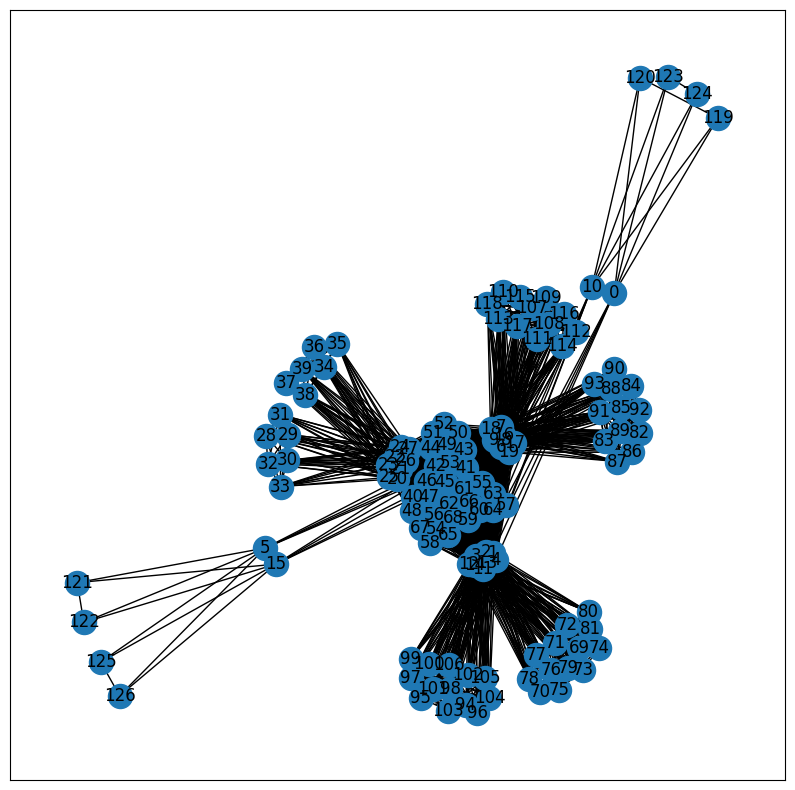

In [12]:
# Plotting and retrieving information about graph structure
fig, axes = plt.subplots(1, num_subgraphs, figsize=(10,10))
subgraph_infos = []

for sg_idx, sg in enumerate(subgraphs):
    subgraph_info_dict = {}
    subgraph_info_dict["avg_degree"] = np.mean([val for val in dict(sg.degree).values()])
    subgraph_infos.append(subgraph_info_dict)
    if num_subgraphs > 1:
        nx.draw_networkx(sg, ax=axes[sg_idx])
    else:
        nx.draw_networkx(sg, ax=axes)

Visualizing the graph does not hold too many information, average connectivity is what matters (because it is relevant for mapping it onto the DWave QPU architecture).

In [13]:
max(dict(subgraphs[0].degree).values())

79

In [14]:
# degree: number of edges connected to a node
print(f"Average degree of the problem graph: {subgraph_infos[0]['avg_degree']:.2f}")
print(f"Maximum degree of the problem graph: {max(dict(subgraphs[0].degree).values())}")

Average degree of the problem graph: 31.81
Maximum degree of the problem graph: 79


In [15]:
num_qubits_with_deg_higher_15 = 0
for val in dict(subgraphs[0].degree).values():
    if val > 15:
        num_qubits_with_deg_higher_15 += 1

print(f"Ratio of nodes with a degree > 15: {num_qubits_with_deg_higher_15/full_num_vars:.2f}")

Ratio of nodes with a degree > 15: 0.81


---
Here we will try the Advantage2.5 prototype, that has up to 20 couplers per qbit. It is in the family of the Pegasus topology

In [17]:


# Heuristically embeds problem graph onto solver graph
#sampler = EmbeddingComposite(DWaveSampler(token=token, solver={"topology__type": topology_type}))
sampler = EmbeddingComposite(DWaveSampler( solver={"name": "Advantage2_prototype2.5"}))

# solve problem
sampleset = sampler.sample_qubo(qubo_dict, num_reads=1000)

# to show warnings and see more confusing graphs :)
# dwinspector.show(sampleset)

In [18]:
# information about how variables were mapped onto qubits
variable_embedding = sampleset.info["embedding_context"]["embedding"]

used_qubits = set()
num_chains = 0
for val in variable_embedding.values():
    if len(val) > 1:
        num_chains += 1
    for entry in val:
        used_qubits.add(entry)
        
print(f"For this problem {full_num_vars} logical variables were mapped onto {len(used_qubits)} qubits")
print(f"For {num_chains} variables multiple qubits had to be combined into a chain")

For this problem 127 logical variables were mapped onto 559 qubits
For 118 variables multiple qubits had to be combined into a chain


## Feasibility

Wanted to test out the feasibility of the solution with the reduced QUBO since I think I saw a feasible solution in one of the earlier runs but I could not reproduce it (which also just underlines that the problem is still not particularly suited for quantum annealing devices in its current form).

In [19]:
# Can be used if sample is from DWave
# full_lowest_energy_sample = sampleset.aggregate().lowest().first.sample

In [20]:
with open("sampleset_full.txt", "r") as file:
    full_lowest_energy_sample = eval(file.read())

In [21]:
# feasibility of solution for the full MIP problem
mip_solution_vec = list(full_lowest_energy_sample.values())[:len(full_mip.variables)]
full_mip.is_feasible(mip_solution_vec)

False

### Solving + checking solution of reduced QUBO

In [22]:
# same procedure as before
reduced_quad_dict = reduced_qubo.objective.quadratic.to_dict()
reduced_linear_dict = reduced_qubo.objective.linear.to_dict()
reduced_var_to_idx_dict = reduced_mip.variables_index

reduced_qubo_dict = {}

for (key0, key1), val in reduced_quad_dict.items():
    if key0 == key1 and key0 in reduced_linear_dict:
        reduced_qubo_dict[(key0, key1)] = val + reduced_linear_dict[key0]
    else:
        reduced_qubo_dict[(key0, key1)] = val

In [24]:
sampler = EmbeddingComposite(DWaveSampler( solver={"name": "Advantage2_prototype2.5"}))

# solve problem
reduced_sampleset = sampler.sample_qubo(reduced_qubo_dict, num_reads=3000)

In [30]:
# information about how variables were mapped onto qubits
variable_embedding = reduced_sampleset.info["embedding_context"]["embedding"]

used_qubits = set()
num_chains = 0
for val in variable_embedding.values():
    if len(val) > 1:
        num_chains += 1
    for entry in val:
        used_qubits.add(entry)
        
print(f"For this problem {full_num_vars} logical variables were mapped onto {len(used_qubits)} qubits")
print(f"For {num_chains} variables multiple qubits had to be combined into a chain")

For this problem 127 logical variables were mapped onto 461 qubits
For 86 variables multiple qubits had to be combined into a chain


In [25]:
# Can be used if sample is from DWave
# reduced_lowest_energy_sample = reduced_sampleset.aggregate().lowest().first.sample

In [26]:
with open("sampleset_reduced.txt", "r") as file:
    reduced_lowest_energy_sample = eval(file.read())

In [27]:
reduced_mip_solution_vec = list(reduced_lowest_energy_sample.values())[:len(reduced_mip.variables)]

reduced_mip.is_feasible(reduced_mip_solution_vec)

False

### Benchmarking with Simulated Annealing

Given enough reads, the simulated annealing solver finds a feasible solution from time to time /:

In [28]:
sim_anneal_sampler = SimulatedAnnealingSampler()
sim_anneal_sampleset = sim_anneal_sampler.sample_qubo(qubo_dict, num_reads=10_000)

In [29]:
sim_anneal_sample = sim_anneal_sampleset.aggregate().lowest().first.sample

sim_anneal_solution_vec = list(sim_anneal_sample.values())[:len(reduced_mip.variables)]

reduced_mip.is_feasible(sim_anneal_solution_vec)

True